In [1]:
import sys
sys.path.append("..")

In [2]:
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor
from squlearn.qnn.lowlevel_qnn import LowLevelQNN
from squlearn.optimizers import Adam
from squlearn.qnn.loss import ODELoss
from squlearn.qnn.training import *
from squlearn.encoding_circuit import *
import numpy as np
import matplotlib.pyplot as plt
from circuits.circuits import SimpleAnalyticalCircuit

L = dfdxdx + k*f(x)

In [3]:
import sympy as sp


def sympy_loss(sp_ode, x_or_f_arguments):
    def np_loss_out_sp(f_alpha_tensor):
        if len(x_or_f_arguments) <= 3:
            return sp.lambdify(x_or_f_arguments, sp_ode, "numpy")(*f_alpha_tensor[:3])
        return sp.lambdify(x_or_f_arguments, sp_ode, "numpy")(*f_alpha_tensor)
    return np_loss_out_sp


def gradient_of_f_arguments_sp(sp_ode, f_arguments):
    """
    Calculate the gradient of a sympy equation with respect to a given set of variables, 
    It replaces the function f_ with a dummy variable f to avoid calculating higher order derivatives of f.

    Args:

    sp_ode (sympy equation): The sp_ode to calculate the gradient of.
    f_arguments (list of sympy symbols): The variables to calculate the gradient with respect to. Assumes [f, dfdx, ...]

    Returns:
    list of sympy equations: The gradient of the sp_ode with respect to the given variables.

    """
    gradients = []
    for f_order in f_arguments:
        gradients.append(sp.diff(sp_ode, f_order))
    return gradients


def gradient_of_f_arguments_np_from_sp(sp_ode, x_or_f_arguments):
    """
    Calculate the gradient of a sympy equation with respect to a given set of variables, 
    It replaces the function f_ with a dummy variable f to avoid calculating higher order derivatives of f.

    Args:

    equation (sympy equation): The equation to calculate the gradient of.
    x_or_f_arguments (list of sympy symbols): Assumes [x, f, dfdx, ...]

    Returns:
    list of sympy equations: The gradient of the equation with respect to the given variables.

    """
    gradients = gradient_of_f_arguments_sp(sp_ode, x_or_f_arguments[1:])
    print(sp_ode)
    print(gradients)
    def np_grad_out_sp(f_alpha_tensor):
        return [sp.lambdify(x_or_f_arguments, grad_i, "numpy")(*f_alpha_tensor) for grad_i in gradients]

    return np_grad_out_sp

In [4]:
x = sp.symbols('x')
f, dfdx, dfdxdx = sp.symbols("f dfdx dfdxdx")
k = 1
eq = sp.cos(x) + k*f 
l_f = sympy_loss(eq, [x, f, dfdx, dfdxdx]) #loss_log_ode
grad_f = gradient_of_f_arguments_np_from_sp(eq, [x, f, dfdx, dfdxdx])

f + cos(x)
[1, 0, 0]


In [5]:
#Our function assume that the input is a tensor of shape (n, 4) where n is the number of points, each entry corresponds to 
#x, f, dfdx and dfdxdx as shown below
def loss_harmonic_oscillator(f_alpha_tensor):
    """
    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]
    Returns:
    loss (np.array): array of shape [F] where F is the loss function
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k=1

    return dfdxdx + k*f

def loss_harmonic_oscillator(f_alpha_tensor):
    """
    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]
    Returns:
    loss (np.array): array of shape [F] where F is the loss function
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k=1

    return dfdx + k*f

def grad_loss_harmonic_oscillator(f_alpha_tensor):
    """
    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]
    Returns:
        grad_loss (np.array): array of shape [dFdf, dFdfdx, dFdfdxdx] 
    where dFdf is the derivative of the loss function with respect to f, dFdfdx is the derivative of the loss function with respect to dfdx and dFdfdxdx is the derivative of the loss function with respect to dfdxdx
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k = 1
    return [k, 0, 1]

In [6]:
x_line = np.linspace(-0.9, 0.9, 15) #x domain to solve the ODE
k = 1

f_initial = [np.cos(np.sqrt(k)*x_line[0]), -np.sin(np.sqrt(k)*x_line[0])] #Initial condition for the ODE
f_initial = [np.cos(np.sqrt(k)*x_line[0])] #Initial condition for the ODE

#Exact result
f_exact = np.cos(np.sqrt(k)*x_line)

In [7]:
num_qubits = 1
num_features = 1
num_layers = 2
circuit = SimpleAnalyticalCircuit(num_qubits, num_features, num_layers)
#circuit = ChebyshevPQC(num_qubits, num_features, num_layers)
executor = Executor("pennylane")

Observables = SummedPaulis(num_qubits, include_identity=False)                                                      
param_obs = Observables.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)

adam = Adam(options={"maxiter": 20, "tol": 0.00009, "log_file": "SHO_DE.log", "skip_mse_fun":False, "lr":0.1})
#loss_harmonic_oscillator, grad_loss_harmonic_oscillator
loss_ODE = ODELoss(l_f, grad_f, initial_vec = f_initial, eta=1, true_solution = f_exact)


ode_regressor = QNNRegressor(
    circuit,
    Observables,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = True, #Parametrized Observables not benchmarked yet
)


In [8]:
ode_regressor.num_parameters

2

In [9]:
ode_regressor

QNNRegressor(encoding_circuit=<squlearn.encoding_circuit.circuit_library.qiskit_encoding_circuit.QiskitEncodingCircuit object at 0x0000026816E6A7A0>,
             executor=<squlearn.util.executor.Executor object at 0x0000026816E6A9E0>,
             loss=<squlearn.qnn.loss.ODELoss object at 0x0000026816E6AEC0>,
             operator=SparsePauliOp(['Z'],
              coeffs=[ParameterExpression(1.0*p[0])]),
             optimizer=<squlearn.optimizers.adam.Adam object at 0x0000026816E6BEB0>,
             param_ini=array([-0.52136612,  1.38433962]),
             param_op_ini=array([1.]))

In [10]:
ode_regressor.fit(x_line, np.zeros((x_line.shape[0])),  weights=None)
f_QNN = ode_regressor.predict(x_line)

fit: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


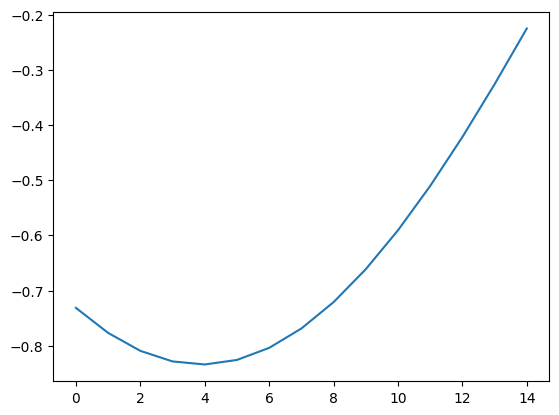

In [11]:
plt.plot(f_QNN)